Code for plotting experimental data (pulls from CSVs)

In [1]:
#for plotting experimental data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pymatgen as mg
import ternary

In [3]:
datadir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\XRD_data')
proc = 'processed'
scriptdir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\scripts')
procdir = os.path.join(datadir,proc)
os.chdir(procdir)

In [4]:
os.chdir(procdir)
#prefix = 'PDAC_COM3'
procdat = pd.DataFrame()

for lib in next(os.walk(procdir))[1]:
    os.chdir(lib)
    pfname = '_'.join([lib,'AllVar.csv'])
        
    if os.path.exists(pfname):
        #read processed file
        proc = pd.read_csv(pfname)
        procdat = procdat.append(proc,ignore_index=True)
    
    os.chdir(procdir)


In [5]:
Bsite = ['Co','Fe','Y','Zr']
compdat = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','sample','structure','substrate'])
for i in procdat.index:
    try:
        comp = mg.Composition(procdat.loc[i,'FORMULA'])
        compdat.loc[i,'formula'] = procdat.loc[i,'FORMULA']
        compdat.loc[i,'fwhm_110'] = procdat.loc[i,'PROPERTY: FWHM of 110 peak ($^{\circ}$)']
        compdat.loc[i,'sample'] = procdat.loc[i,'IDENTIFIER: Sample number']
        compdat.loc[i,'structure'] = procdat.loc[i,'PROPERTY: Structure']
        compdat.loc[i,'substrate'] = procdat.loc[i,'PREPARATION STEP DETAIL: Substrate']
        for el in Bsite:
            compdat.loc[i,el] = comp.get_el_amt_dict()[el]
    except Exception: #Sample 1256 has negative Fe amt, just ignore for now
        pass

In [6]:
#check substrates - need to remove ITO/EXG
for s in procdat['PREPARATION STEP DETAIL: Substrate'].unique():
    sdf = procdat[procdat['PREPARATION STEP DETAIL: Substrate']==s]
    print('{}: {}'.format(s,len(sdf)))
    print(sdf['IDENTIFIER: Sample number'].unique())

EXG: 748
[1023 1024 1025 1026 1027 1226 1227 1228 1229 1300 1329 1330 1331 1333
 1338 1343 1344]
SiO2: 1892
[1028 1029 1030 1031 1084 1085 1086 1087 1088 1097 1098 1099 1100 1119
 1120 1121 1122 1124 1125 1126 1129 1130 1137 1138 1139 1140 1157 1158
 1159 1184 1185 1186 1187 1199 1200 1230 1231 1232 1233 1252 1502 1503
 1505]
ITO/EXG: 132
[1251 1256 1257]


ValueError: not enough values to unpack (expected 2, got 0)

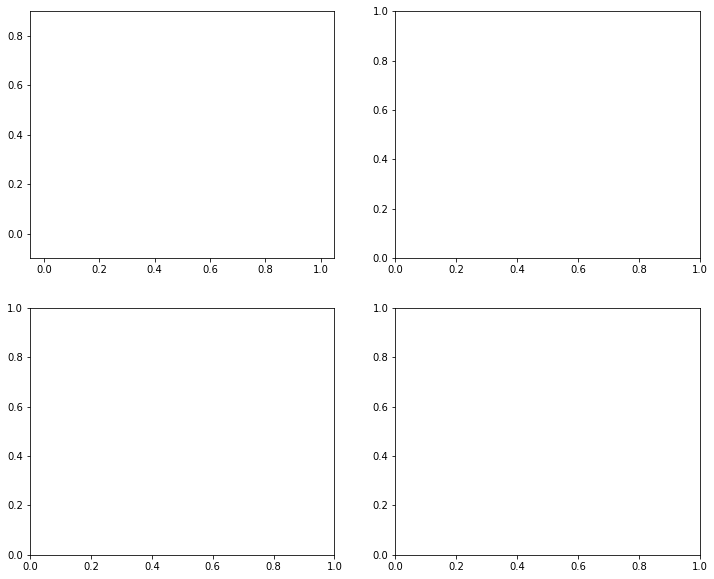

In [7]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compdat.loc[:,'fwhm_110'].values
vmin = 0.4
vmax = 0.7
ignore = []

for i, nY in enumerate(Y_frac):
    df = compdat[(compdat['Y']>=nY - 0.05) & (compdat['Y']<nY + 0.05) & (compdat['sample'].isin(ignore)==False)]
    df = df[df['substrate'].isin(['SiO2','EXG'])]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'fwhm_110'].replace(np.nan,10).values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum
    
    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    #cmap.set_bad('gray',1.) #doesn't seem to work
    cmap.set_over('darkgray',1.) #make nans grey
    tax.scatter(scaled_pts,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(max(0,nY-0.05),min(nY+0.05,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
        
plt.suptitle('Experimental 110 FWHM vs. B-Site Composition',size=16,y=0.97)

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('110 FWHM', fontsize=12, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

#plt.savefig(os.path.join(scriptdir,'plots','Bsite_fwhm110_ternary_exp_180424.png'),dpi=350)

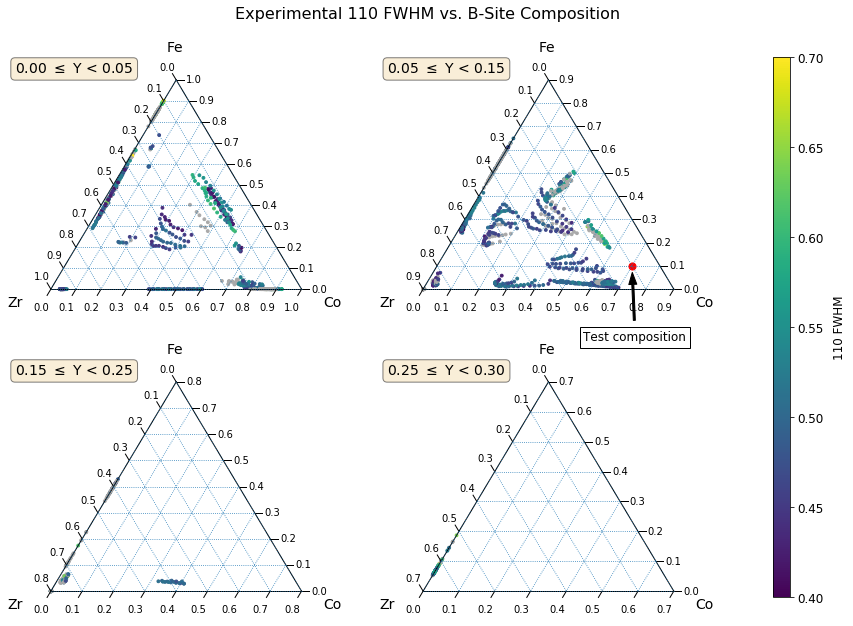

In [145]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compdat.loc[:,'fwhm_110'].values
vmin = 0.4
vmax = 0.7
ignore = []

for i, nY in enumerate(Y_frac):
    df = compdat[(compdat['Y']>=nY - 0.05) & (compdat['Y']<nY + 0.05) & (compdat['sample'].isin(ignore)==False)]
    df = df[df['substrate'].isin(['SiO2','EXG'])]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'fwhm_110'].replace(np.nan,10).values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum
    
    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    #cmap.set_bad('gray',1.) #doesn't seem to work
    cmap.set_over('darkgray',1.) #make nans grey
    tax.scatter(scaled_pts,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(max(0,nY-0.05),min(nY+0.05,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
    
    #add marker for recommended test composition
    if nY == 0.1:
        coord = (0.7,0.1,0.1)
        tax.scatter([coord],s=50,c='r',marker='o')
        tax.annotate('Test composition',position=coord, 
                     xytext = (0.76,-0.18), fontsize=12, horizontalalignment='center', verticalalignment='center',
                     bbox=dict(boxstyle='square',fc='white'),
                     arrowprops=dict(facecolor='k',shrink=0.1,width = 2,headwidth=8))
        
plt.suptitle('Experimental 110 FWHM vs. B-Site Composition',size=16,y=0.97)

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('110 FWHM', fontsize=12, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

plt.savefig(os.path.join(scriptdir,'plots','Bsite_fwhm110_ternary_exp_annotated_180425.png'),dpi=350)

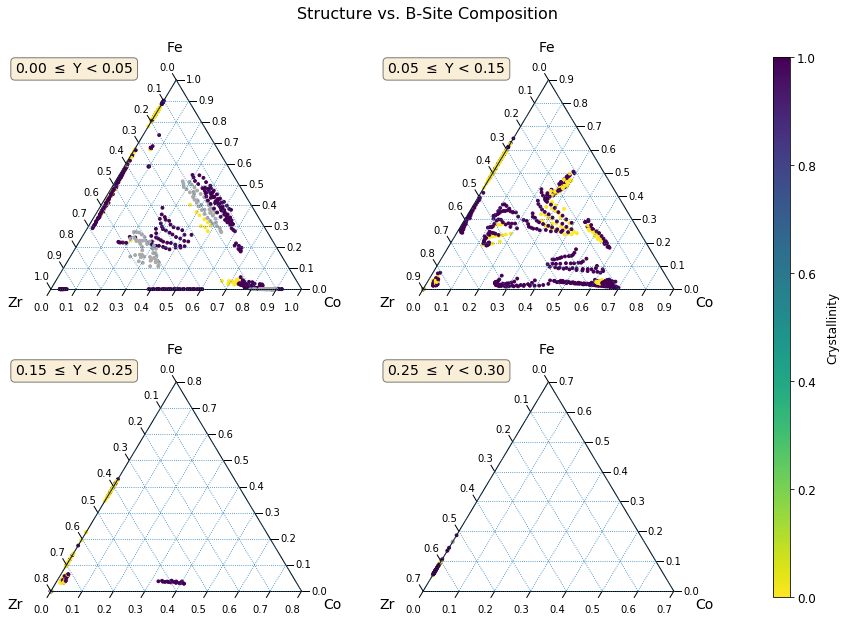

In [56]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compdat.loc[:,'fwhm_110'].values
vmin = 0
vmax = 1
ignore = []

for i, nY in enumerate(Y_frac):
    df = compdat[(compdat['Y']>=nY - 0.05) & (compdat['Y']<nY + 0.05) & (compdat['sample'].isin(ignore)==False)]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df['structure'].map({'Crystalline':vmin,'Amorphous':vmax}).replace(np.nan,10).values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum
    
    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis_r #reversed
    cmap.set_over('darkgray',1.) #make nans grey
    p = tax.scatter(scaled_pts,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(max(0,nY-0.05),min(nY+0.05,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
        
plt.suptitle('Structure vs. B-Site Composition',size=16,y=0.97)

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('Crystallinity', fontsize=12, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

#plt.savefig(os.path.join(scriptdir,'plots','Bsite_fwhm110_ternary_exp_180424.png'),dpi=350)

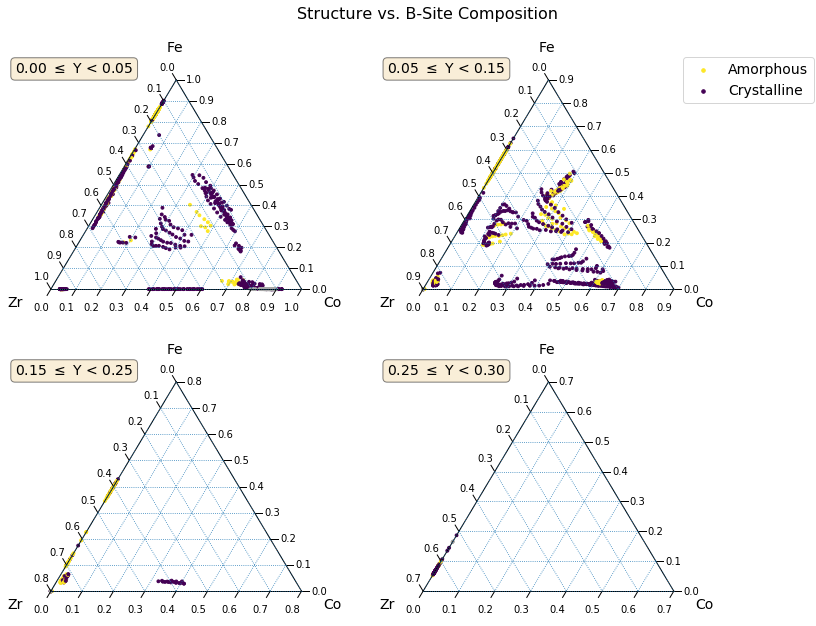

In [143]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compdat.loc[:,'fwhm_110'].values
vmin = 0
vmax = 1
ignore = []

for i, nY in enumerate(Y_frac):
    df = compdat[(compdat['Y']>=nY - 0.05) & (compdat['Y']<nY + 0.05) & (compdat['sample'].isin(ignore)==False)]
    df = df[df['substrate'].isin(['SiO2','EXG'])]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df['structure'].map({'Crystalline':vmin,'Amorphous':vmax}).replace(np.nan,10).values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum
    
    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis_r
    cmap.set_over('darkgray',1.) #make nans grey
    tax.scatter(scaled_pts,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(max(0,nY-0.05),min(nY+0.05,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
        
plt.suptitle('Structure vs. B-Site Composition',size=16,y=0.97)

plt.scatter(x=[-0.5],y=[-0.5],marker='.', s=50, c = cmap.colors[0], label='Amorphous')
plt.scatter(x=[-0.5],y=[-0.5],marker='.', s=50, c = cmap.colors[-1], label='Crystalline')
#plt.scatter(x=[-0.5],y=[-0.5],marker='.', s=50, c = 'darkgray', label='No Structure Data')

# #add a single colorbar
# #make an axis for colorbar to control position/size
# cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
# #code from colormapping.colorbar_hack
# norm = plt.Normalize(vmin=vmin, vmax=vmax)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm._A = []
# cb = fig.colorbar(sm, ax=axes, cax = cbaxes, ticks=[vmin,vmax])
# cb.set_label('Crystallinity', fontsize=12, labelpad=10)
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_yticklabels(['Amorphous','Crystalline'])


fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)
fig.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.95,0.8))
plt.savefig(os.path.join(scriptdir,'plots','structure_ternary_exp_180425.png'),dpi=350)

In [130]:
len(cmap.colors)

256

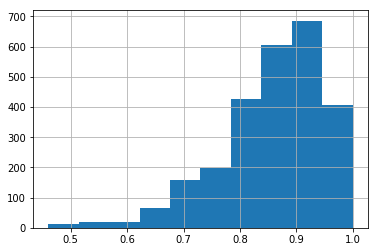

In [14]:
for i in compdat.index:
    comp = mg.Composition(compdat.loc[i,'formula'])
    compdat.loc[i,'Ba'] = comp.get_el_amt_dict()['Ba']

compdat['Ba'].min(), compdat['Ba'].max(), compdat['Ba'].mean()

compdat['Ba'].hist()

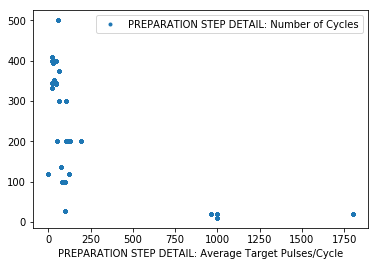

In [20]:
procdat.plot('PREPARATION STEP DETAIL: Average Target Pulses/Cycle','PREPARATION STEP DETAIL: Number of Cycles', ls='',marker='.')

In [21]:
procdat['Total Pulses'] = procdat['PREPARATION STEP DETAIL: Average Target Pulses/Cycle']*procdat['PREPARATION STEP DETAIL: Number of Cycles']

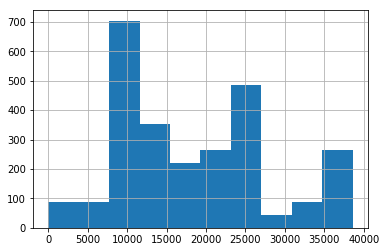

In [23]:
procdat['Total Pulses'].hist()

In [38]:
for sub in procdat['PREPARATION STEP DETAIL: Substrate'].unique():
    print (sub, len(procdat[procdat['PREPARATION STEP DETAIL: Substrate']==sub]))

EXG 748
SiO2 1760
ITO/EXG 132


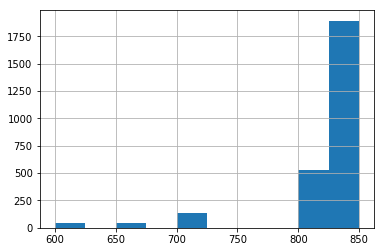

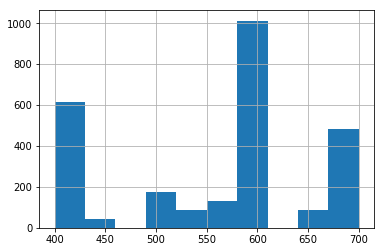

In [34]:
procdat['PREPARATION STEP DETAIL: Temperature ($^{\circ}$C)'].hist()
plt.show()
procdat['PREPARATION STEP DETAIL: Laser Energy (mJ)'].hist()

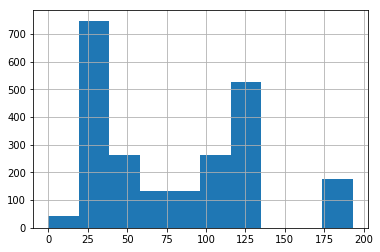

In [32]:
procdat[procdat['PREPARATION STEP DETAIL: Average Target Pulses/Cycle']<=500]['PREPARATION STEP DETAIL: Average Target Pulses/Cycle'].hist()

In [40]:
procdat['PREPARATION STEP DETAIL: Substrate'].unique()

array(['EXG', 'SiO2', 'ITO/EXG'], dtype=object)

In [15]:
procdat.iloc[0,:]

FORMULA                                                 Ba0.8306Co0.0Fe0.05998Y0.2881Zr0.65192O3
IDENTIFIER: Column                                                                             1
IDENTIFIER: Date                                                                      9_Feb_2016
IDENTIFIER: Point                                                                              1
IDENTIFIER: Row                                                                                1
IDENTIFIER: Sample number                                                                   1023
IDENTIFIER: X position (mm)                                                                  5.4
IDENTIFIER: Y position (mm)                                                               44.142
PREPARATION STEP DETAIL: Average Target Pulses/Cycle                                        1000
PREPARATION STEP DETAIL: B12ZY82 Pulses/Cycle                                                  0
PREPARATION STEP DETAIL: B12ZY